# Topic Modeling
### ... in a nutshell:

<img src="https://moj-analytical-services.github.io/NLP-guidance/LDAresults.png" alt="lda" style="width: 600px;"/>

Partially pased on [this blogpost](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) by Selva Prabhakaran.

In [92]:
import sys
import logging
import pandas as pd
import re, numpy as np
from pprint import pprint

import warnings

We will need to draw some plots:

In [93]:
%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

We again use Gensim library, but now we work with its topic modelling features.

In [94]:
# Gensim
import gensim, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

NLTK toolkit provides us with a corpus and additional tools:

In [95]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

We use Architectural features and indoor evacuation wayfinding for testing:

In [96]:
with open('/home/timur/Desktop/jupyter wf/ArchTScince/article_splitted_by_sent.txt') as f:
    article = f.readlines()

In [97]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(article, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[article], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [98]:
# #     for sent in texts:
#         texts_out.append([wnl.lemmatize(token) for token in sent])

In [99]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(article)  # processed Text Data!

In [100]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [101]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abstract', 1),
  ('aesthetically', 1),
  ('attracted', 1),
  ('configuration', 1),
  ('content', 1),
  ('environmental', 1),
  ('field', 1),
  ('finding', 1),
  ('human', 1),
  ('landscape', 1),
  ('natural', 1),
  ('particular', 1),
  ('psychology', 1),
  ('review', 1),
  ('show', 1)]]

The topic modelling we use is Latent Dirichlet Allocation. We have to skip the details here, but you can find all the details in [the original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf).

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.022*"level" + 0.017*"cultural" + 0.016*"argument" + 0.014*"well" + '
  '0.014*"different" + 0.014*"presented" + 0.012*"characteristic" + '
  '0.011*"work" + 0.010*"like" + 0.008*"become"'),
 (1,
  '0.085*"fractal" + 0.027*"biophilic" + 0.023*"architecture" + '
  '0.019*"natural" + 0.017*"nature" + 0.015*"dimension" + 0.015*"response" + '
  '0.014*"pattern" + 0.013*"aesthetic" + 0.012*"human"'),
 (2,
  '0.024*"example" + 0.021*"architectural" + 0.016*"setting" + '
  '0.016*"geometry" + 0.015*"feature" + 0.015*"structure" + '
  '0.014*"environment" + 0.011*"certain" + 0.011*"complexity" + 0.010*"scale"'),
 (3,
  '0.036*"architecture" + 0.019*"however" + 0.018*"form" + 0.014*"habitat" + '
  '0.014*"sense" + 0.013*"building" + 0.013*"natural" + 0.012*"element" + '
  '0.011*"specific" + 0.011*"design"')]


In [103]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.120977458364802

Coherence Score:  0.4449222950955827


Let us see on the corpus and output model more precisely:

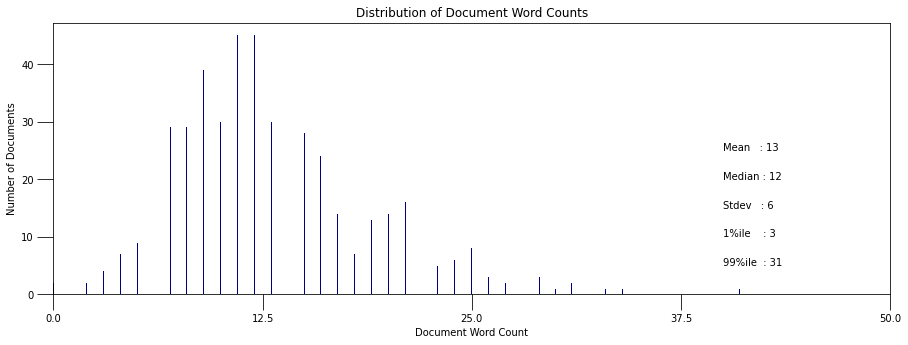

In [104]:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(15, 5))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(40,  25, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(40,  20, "Median : " + str(round(np.median(doc_lens))))
plt.text(40,  15, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(40,  10, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(40,  5, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 30), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,50,5))
plt.title('Distribution of Document Word Counts')
plt.show()

In [105]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

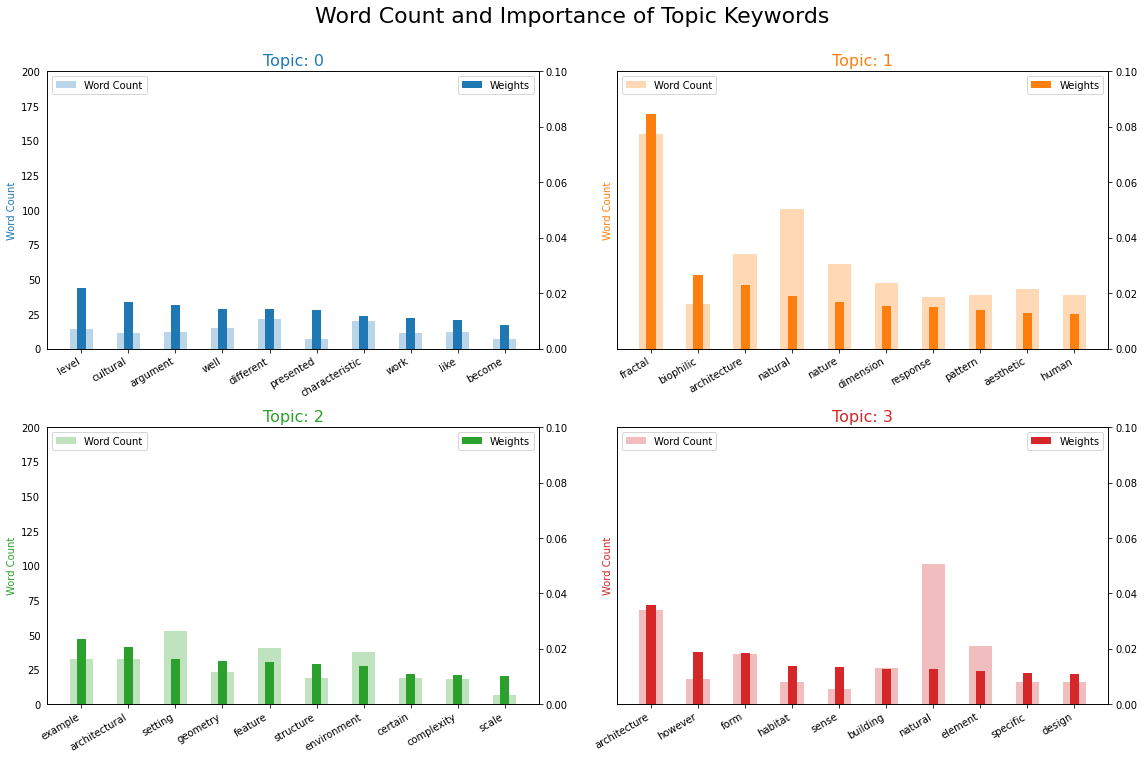

In [106]:
# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show();

In [107]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(22, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

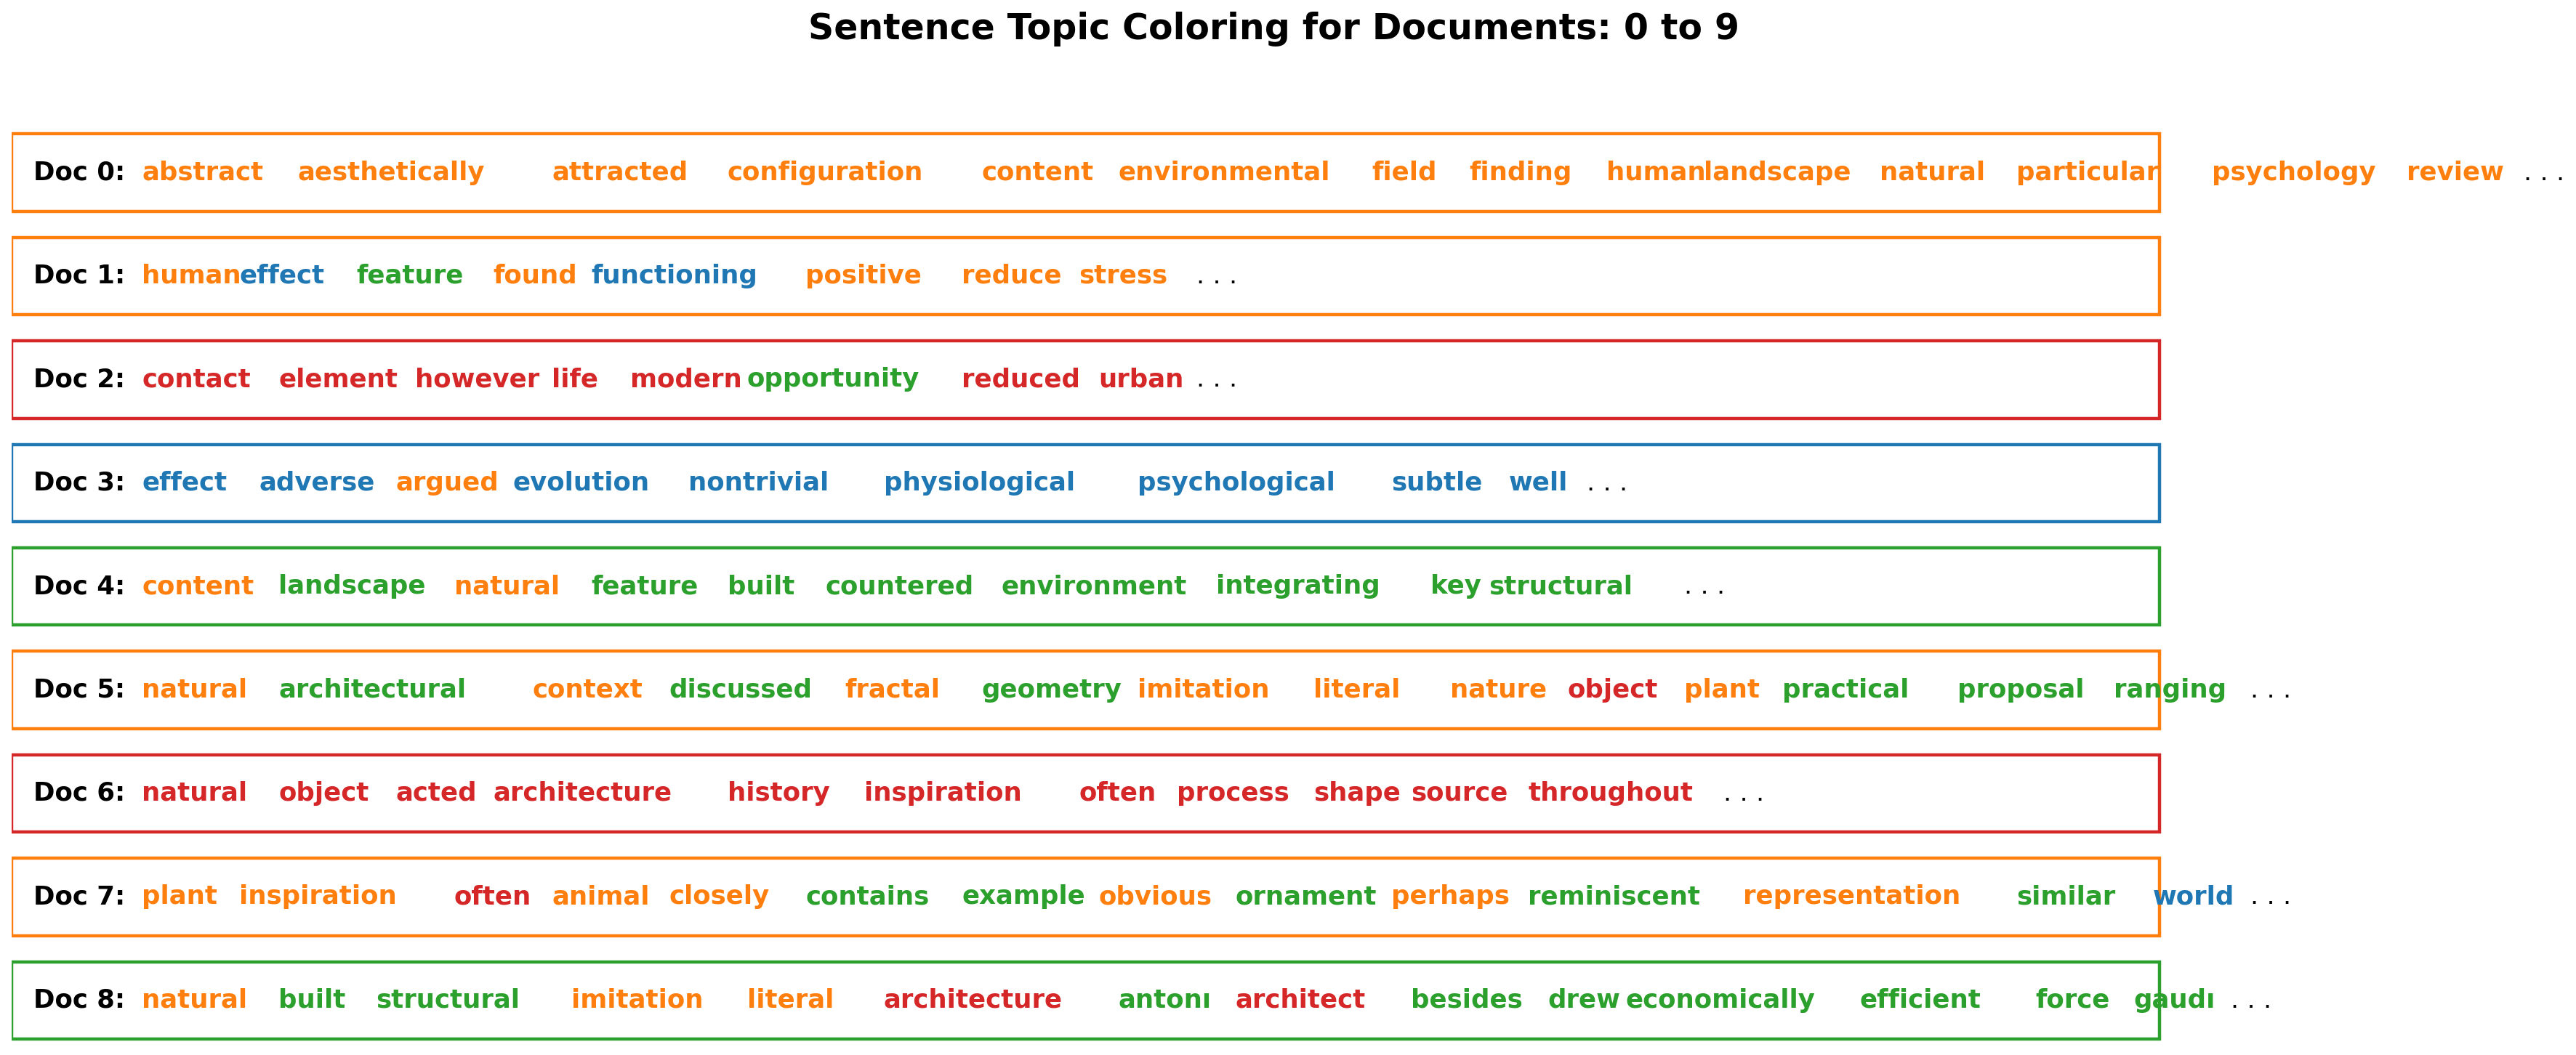

In [108]:
sentences_chart()  

For the final part we need an additional tool for visualization:

In [109]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.228078 -0.049754       1        1  33.615819
3     -0.022280  0.202310       2        1  23.928365
2     -0.098960 -0.056325       3        1  22.606591
0     -0.106838 -0.096231       4        1  19.849225, topic_info=              Term        Freq       Total Category  logprob  loglift
47         fractal  182.000000  182.000000  Default  30.0000  30.0000
59    architecture  104.000000  104.000000  Default  29.0000  29.0000
536      biophilic   57.000000   57.000000  Default  28.0000  28.0000
70         example   34.000000   34.000000  Default  27.0000  27.0000
724          level   28.000000   28.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1269    successful   10.414362   12.728978   Topic4  -4.8031   1.4163
975      ancestral    6.764791    7.843056   Topic4  -5.2345   1.4691
1775         trend    6.600065    7.766542   Topic4  -5.2592   1.4543
1035        social    6.676108    8.644803   Topic4  -5.2477   1.3586
1883         taste    9.666151   25.350398   Topic4  -4.8776   0.6528

[174 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
303       2  0.949294  according
660       1  0.965259    account
483       2  0.953834     actual
146       1  0.982037  aesthetic
220       1  0.991286  affective
...     ...       ...        ...
1847      3  0.088681      whole
1847      4  0.177361      whole
610       4  0.965573       work
77        4  0.907043      world
644       4  0.892378        yet

[169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [110]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready, document=article):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    based_text = pd.Series(article)
    sent_topics_df = pd.concat([sent_topics_df, contents, based_text], axis=1)
    
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready, document=article)



# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Article']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Article
0,0,1.0,0.9521,"fractal, biophilic, architecture, natural, nat...","[abstract, review, finding, field, environment...",Abstract: A review of findings from the field ...
1,1,1.0,0.5724,"fractal, biophilic, architecture, natural, nat...","[feature, found, positive, effect, human, func...",These features are also found to have positive...
2,2,3.0,0.8112,"architecture, however, form, habitat, sense, b...","[however, opportunity, contact, element, reduc...","However, opportunities for contact with these ..."
3,3,0.0,0.8175,"level, cultural, argument, well, different, pr...","[argued, evolution, subtle, nontrivial, advers...",It is argued how this evolution can have subtl...
4,4,2.0,0.7677,"example, architectural, setting, geometry, fea...","[countered, integrating, key, feature, natural...",These can be countered by integrating key feat...
5,5,1.0,0.4764,"fractal, biophilic, architecture, natural, nat...","[several, practical, proposal, discussed, rang...","Several practical proposals are discussed, ran..."
6,6,3.0,0.9361,"architecture, however, form, habitat, sense, b...","[natural, object, shape, process, often, acted...","\tNatural objects, shapes, and processes have ..."
7,7,1.0,0.4932,"fractal, biophilic, architecture, natural, nat...","[perhaps, obvious, example, inspiration, ornam...",Perhaps the most obvious example of this inspi...
8,8,2.0,0.6717,"example, architectural, setting, geometry, fea...","[besides, literal, imitation, architect, notab...","Besides such literal imitations, some architec..."
9,9,1.0,0.7773,"fractal, biophilic, architecture, natural, nat...","[today, seems, renewed, interest, relation, na...","Today, there seems to be a renewed interest in..."


In [117]:
df_dominant_topic.sort_values(by='Topic_Perc_Contrib' ,ascending=False).head(90).reset_index()

,index,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Article
0,129,129,1.0,0.9564,"fractal, biophilic, architecture, natural, nat...","[particular, made, historical, study, word, di...","In particular, they made a historical study of..."
1,458,458,0.0,0.9525,"level, cultural, argument, well, different, pr...","[course, prevailing, cultural, taste, clash, b...","Of course, prevailing cultural tastes could cl..."
2,0,0,1.0,0.9521,"fractal, biophilic, architecture, natural, nat...","[abstract, review, finding, field, environment...",Abstract: A review of findings from the field ...
3,82,82,3.0,0.9484,"architecture, however, form, habitat, sense, b...","[furthermore, openness, savanna, facilitates, ...","Furthermore, the openness of savannas facilita..."
4,84,84,1.0,0.9483,"fractal, biophilic, architecture, natural, nat...","[balling, falk, found, young, individual, pref...",Balling and Falk (1982) found that young indiv...
...,...,...,...,...,...,...,...
85,260,260,0.0,0.8011,"level, cultural, argument, well, different, pr...","[however, original, rectangle, elongated, rat,...","However, when the original rectangle is elonga..."
86,311,311,1.0,0.7975,"fractal, biophilic, architecture, natural, nat...","[search, stronger, foundation, fractal, aesthe...",In search for a stronger foundation for fracta...
87,410,410,1.0,0.7962,"fractal, biophilic, architecture, natural, nat...","[although, research, needed, finding, lends, s...","Although further research is needed, this find..."
88,313,313,1.0,0.7952,"fractal, biophilic, architecture, natural, nat...","[yet, noted, arthur, stamp, tested, conclusion...",Yet it should also be noted that Arthur Stamps...


In [112]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'Article']

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Article
0,0.0,0.9525,"level, cultural, argument, well, different, pr...","[course, prevailing, cultural, taste, clash, b...","Of course, prevailing cultural tastes could cl..."
1,1.0,0.9564,"fractal, biophilic, architecture, natural, nat...","[particular, made, historical, study, word, di...","In particular, they made a historical study of..."
2,2.0,0.9230,"example, architectural, setting, geometry, fea...","[prospect, refuge, linked, predictor, complexi...",\tProspect and refuge can be linked to the pre...
3,3.0,0.9484,"architecture, however, form, habitat, sense, b...","[furthermore, openness, savanna, facilitates, ...","Furthermore, the openness of savannas facilita..."


/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna